The scheme to implement a model with keras:

* Architecture of the model
* Compiling the model
* Training of the model Diagnosis of the training
* Evaluation of predictions

In [13]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.cm as cm
%matplotlib inline

* loading and preprocessing the dataset

In [2]:
dataset_path = '../../../IAM_Words/words'  # Update the path as necessary
data = []
words = open("../ascii/words.txt", "r").readlines()
inexistent_or_corrupted= 0

for line in tqdm(words):
    if line.startswith("#"):
        continue
    parts = line.strip().split()
    fixed_part = parts[:8]
    transcription_part = ' '.join(parts[8:])

    line_split = line.split(" ")
    folder_parts = line_split[0].split('-')
    folder1 = folder_parts[0]
    folder2 = folder_parts[0] + '-' + folder_parts[1]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')
    rel_path = os.path.join(dataset_path, folder1, folder2, file_name)

    if os.path.exists(rel_path) and os.path.getsize(rel_path) > 0:
        data.append(fixed_part + [transcription_part, rel_path])
    else:
        inexistent_or_corrupted += 1

print('inexistent_or_corrupted', inexistent_or_corrupted)
df = pd.DataFrame(data, columns=['line_id', 'result', 'graylevel', 'x', 'y', 'w', 'h', 'annotation', 'transcription', 'image_path'])
display(df.head())

  0%|          | 0/115338 [00:00<?, ?it/s]

100%|██████████| 115338/115338 [00:00<00:00, 120054.57it/s]


inexistent_or_corrupted 2


,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../../IAM_Words/words/a01/a01-000u/a01-000u...
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../../IAM_Words/words/a01/a01-000u/a01-000u...
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../../IAM_Words/words/a01/a01-000u/a01-000u...
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../../IAM_Words/words/a01/a01-000u/a01-000u...
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../../IAM_Words/words/a01/a01-000u/a01-000u...


* check transcription distribution and remove transcriptions with fewer than 2 samples 

In [3]:
# Check transcription distribution
print("Transcription distribution before filtering:")
print(df['transcription'].value_counts())

# Remove transcription with fewer than 2 samples
min_samples = 2
class_counts = df['transcription'].value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index
df_filtered = df[df['transcription'].isin(classes_to_keep)].copy()
# reset index after manipulation
df_filtered.reset_index(drop=True, inplace=True)

# Check transcription distribution after filtering
print("Transcription distribution after filtering:")
print(df_filtered['transcription'].value_counts())

le = LabelEncoder()
df_filtered['transcription_encoded'] = None
df_filtered['transcription_encoded'] = le.fit_transform(df_filtered['transcription'])

display(df_filtered.info())
display(df_filtered.head())

Transcription distribution before filtering:
transcription
the           5826
,             5570
.             4984
of            3192
to            2651
              ... 
dimensions       1
painting         1
cutters          1
Parana           1
hullo            1
Name: count, Length: 13550, dtype: int64
Transcription distribution after filtering:
transcription
the          5826
,            5570
.            4984
of           3192
to           2651
             ... 
specified       2
palm            2
smoothing       2
gate            2
doorman         2
Name: count, Length: 6360, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108128 entries, 0 to 108127
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   line_id                108128 non-null  object
 1   result                 108128 non-null  object
 2   graylevel              108128 non-null  object
 3   x                  

None

,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path,transcription_encoded
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../../IAM_Words/words/a01/a01-000u/a01-000u...,116
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../../IAM_Words/words/a01/a01-000u/a01-000u...,850
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../../IAM_Words/words/a01/a01-000u/a01-000u...,5884
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../../IAM_Words/words/a01/a01-000u/a01-000u...,5573
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../../IAM_Words/words/a01/a01-000u/a01-000u...,930


* preparing image data

In [4]:
X, Y = [], []
width, height = 28, 28  # Resize to 28x28

for index, row in df_filtered.iterrows():
    image = Image.open(row['image_path']).convert('RGB').resize((width, height))
    X.append(np.array(image))
    Y.append(row['transcription_encoded'])

X = np.array(X) / 255.0  # Normalize images
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))
Y = np.array(Y)

print('X and Y have the same length ',len(X) == len(Y))


Min: 0.000, Max: 1.000
X and Y have the same length  True


* Train and testing split (70/30)

In [5]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)


translation = off


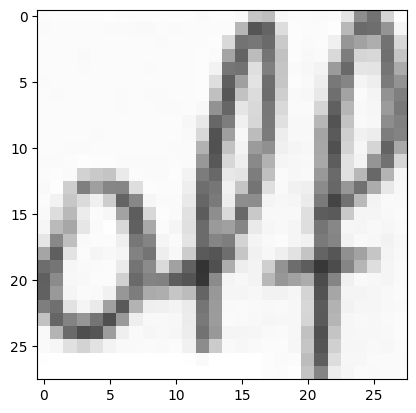

In [6]:
#Display a random image from the dataset (take any number from the random state)

idx = df_filtered.loc[df_filtered['transcription_encoded'] == Y_train[0]].index[0]
print('translation =', df_filtered['transcription'].iloc[idx])
plt.imshow(X_train[0])
plt.show()

* transforming data into 4-dimensional array (images, width, height, depth)
* One-hot encoding for labels

In [7]:
# Reshape for CNN
X_train = X_train.reshape((-1, 28, 28, 3))  # Adjust channels to 3 for RGB
X_test = X_test.reshape((-1, 28, 28, 3))

# Adding class weights to improve class balance
class_weights = compute_class_weight(
 class_weight='balanced',
 classes=np.unique(Y_train),
 y=Y_train)

# One-hot encoding for labels
num_classes = max(len(np.unique(Y_train)), len(np.unique(Y_test)))
y_train = to_categorical(Y_train, num_classes=num_classes)
y_test = to_categorical(Y_test, num_classes=num_classes)

# check if one hot encoding was successful
display(np.unique(Y_train).shape)
display(y_train.shape)
display(np.argmax(y_train))
display(len(np.unique(Y_train)))

(6360,)

(75689, 6360)

4335

6360

* CNN Architecture

* Creating and Training the model

In [8]:
# CNN Model
inputs_cnn = Input(shape=(28, 28, 3))  # Adjust shape for RGB
x = Conv2D(32, (5, 5), activation='relu')(inputs_cnn)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
num_classes = y_train.shape[1]  # Number of classes
outputs_cnn = Dense(num_classes, activation='softmax')(x)

# Compile model
model_cnn = Model(inputs=inputs_cnn, outputs=outputs_cnn)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
training_history_cnn = model_cnn.fit(X_train, y_train,
                                     validation_split=0.2,
                                     epochs=15,
                                     batch_size=200,
                                     verbose=1,
                                     #class_weight=class_weights
                                     )


Epoch 1/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.1001 - loss: 6.7853 - val_accuracy: 0.2484 - val_loss: 5.2653
Epoch 2/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.2839 - loss: 4.8458 - val_accuracy: 0.3328 - val_loss: 4.5592
Epoch 3/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.3600 - loss: 4.0485 - val_accuracy: 0.3867 - val_loss: 4.1461
Epoch 4/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.4076 - loss: 3.4534 - val_accuracy: 0.4223 - val_loss: 3.9227
Epoch 5/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.4531 - loss: 2.9061 - val_accuracy: 0.4439 - val_loss: 3.8240
Epoch 6/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.5006 - loss: 2.4311 - val_accuracy: 0.4549 - val_loss: 3.8630
Epoch 7/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5470 - loss: 2.0659 - val_accuracy: 0.4661 - val_loss: 3.9506
Epoch 8/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.6009 - loss: 1.7681 - 

* Performance of the CNN model

* Plot of evolution of accuracies throughout the training

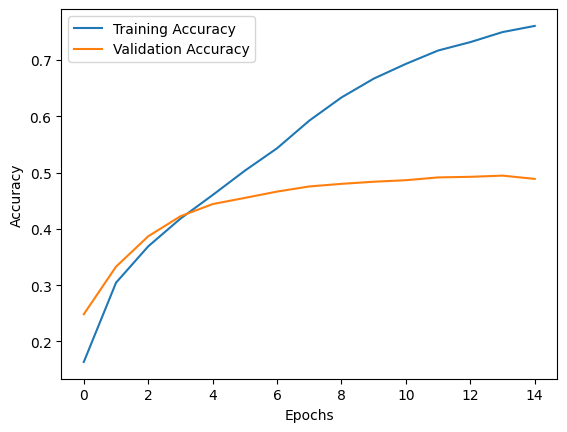

In [9]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

# Training sample accuracy curve
plt.plot(train_acc_cnn, label='Training Accuracy')
# Test sample accuracy curve
plt.plot(val_acc_cnn, label='Validation Accuracy')
# Axis labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

* displaying detailed evaluative report of model's performance

In [10]:
test_pred = model_cnn.predict(X_test)
test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

#print(metrics.classification_report(y_test_class, test_pred_class))
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)

# Extracting mean values
mean_precision = report['weighted avg']['precision']
mean_recall = report['weighted avg']['recall']
mean_f1_score = report['weighted avg']['f1-score']

# Output the mean values
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-Score: {mean_f1_score:.2f}')

1014/1014 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Mean Precision: 0.49
Mean Recall: 0.50
Mean F1-Score: 0.48


/home/cloud/Documents/MachineLearningEngineer_Datascientest/project/OCR/OCR2/OCR_handwriting/OCR2_env/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cloud/Documents/MachineLearningEngineer_Datascientest/project/OCR/OCR2/OCR_handwriting/OCR2_env/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cloud/Documents/MachineLearningEngineer_Datascientest/project/OCR/OCR2/OCR_handwriting/OCR2_env/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetri

* displaying confusion matrix between y_test_class and test_pred_class

In [11]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)

[[ 47   0   0 ...   0   0   0]
 [  1 323   1 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


* displaying random images that the model got wrong

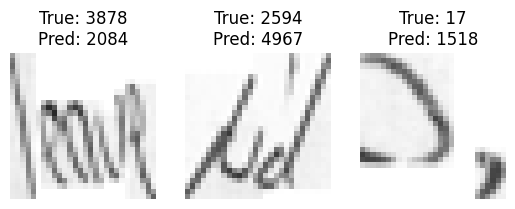

In [12]:
# Create mapping from class indices to transcriptions
class_mapping = {index: transcription for index, transcription in enumerate(pd.Series(Y).unique())}

# Handling error indexes
error_indexes = [i for i in range(len(test_pred)) if test_pred_class[i] != y_test_class[i]]

if len(error_indexes) > 0:
    j = 1
    for i in np.random.choice(error_indexes, size=min(3, len(error_indexes)), replace=False):
        img = X_test[i]
        plt.subplot(1, 3, j)
        plt.axis('off')
        plt.imshow(img, cmap=cm.binary)

        true_transcription = Y_test[i]  # Get true transcription directly from the original labels
        predicted_transcription = class_mapping[test_pred_class[i]]  # Get predicted transcription

        plt.title(f'True: {true_transcription}\nPred: {predicted_transcription}')
        j += 1
    plt.show()
else:
    print("No errors in predictions.")